C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment v

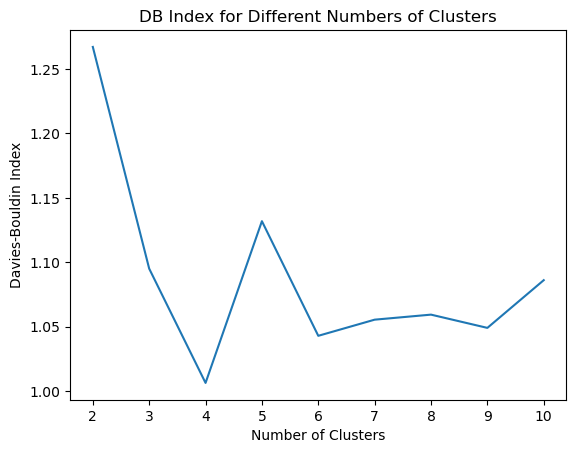

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


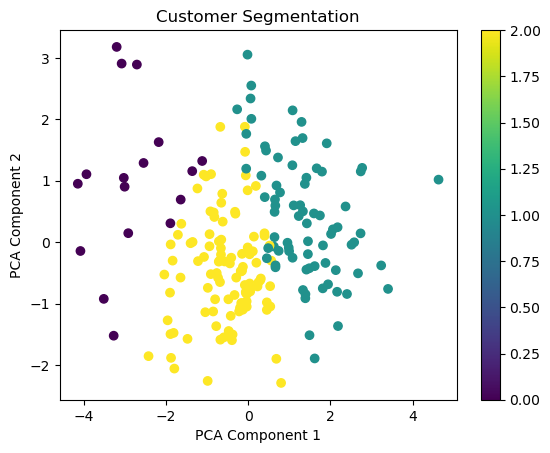

Optimal number of clusters: 3
DB Index for 3 clusters: 1.095060790183532


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Step 1: Load the Data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Step 2: Merge the DataFrames
merged_df = pd.merge(customers_df, transactions_df, on='CustomerID', how='left')

# Step 3: Feature Engineering

# Calculate total transaction value and transaction count per customer
customer_transactions = merged_df.groupby('CustomerID').agg(
    TotalTransactionValue=('TotalValue', 'sum'),
    TransactionCount=('TransactionID', 'count')
).reset_index()

# Calculate the average transaction value per customer
customer_transactions['AverageTransactionValue'] = customer_transactions['TotalTransactionValue'] / customer_transactions['TransactionCount']

# Calculate recency (days since last transaction)
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])
most_recent_transaction = merged_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
most_recent_transaction['Recency'] = (pd.to_datetime('today') - most_recent_transaction['TransactionDate']).dt.days

# Merge the customer-level transaction features with customer profile data
final_df = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left')
final_df = pd.merge(final_df, most_recent_transaction[['CustomerID', 'Recency']], on='CustomerID', how='left')

# Step 4: Select Features for Clustering
features = ['TotalTransactionValue', 'TransactionCount', 'AverageTransactionValue', 'Recency']

# Drop rows with missing values in selected features
final_df = final_df.dropna(subset=features)

# Step 5: Standardize the Features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df[features])

# Step 6: Perform Clustering (K-Means) and Calculate DB Index
db_scores = []
for k in range(2, 11):  # Try with 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    db_score = davies_bouldin_score(scaled_data, kmeans.labels_)
    db_scores.append(db_score)

# Plot DB Index vs Number of Clusters
plt.plot(range(2, 11), db_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('DB Index for Different Numbers of Clusters')
plt.show()

# Step 7: Apply K-Means with the Optimal Number of Clusters (let's assume it's 3)
optimal_k = 3  # You can choose the k that gives the best DB index
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(scaled_data)

# Step 8: Visualize the Clusters
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Plot the clusters
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segmentation')
plt.colorbar()
plt.show()

# Step 9: Final Results (Number of Clusters and DB Index)
print(f"Optimal number of clusters: {optimal_k}")
print(f"DB Index for {optimal_k} clusters: {db_scores[optimal_k - 2]}")

In [4]:
# Analyze the cluster characteristics
final_df['Cluster'] = labels
cluster_summary = final_df.groupby('Cluster')[features].mean()
print(cluster_summary)

         TotalTransactionValue  TransactionCount  AverageTransactionValue  \
Cluster                                                                     
0                  1070.562353          1.764706               563.316716   
1                  5363.542105          6.657895               843.387988   
2                  2492.139623          4.377358               595.797971   

            Recency  
Cluster              
0        274.176471  
1         91.684211  
2         86.141509  
